In [1]:
import matplotlib
from graph_tool.all import *
import numpy as np
import pickle
import matplotlib.pyplot as plt

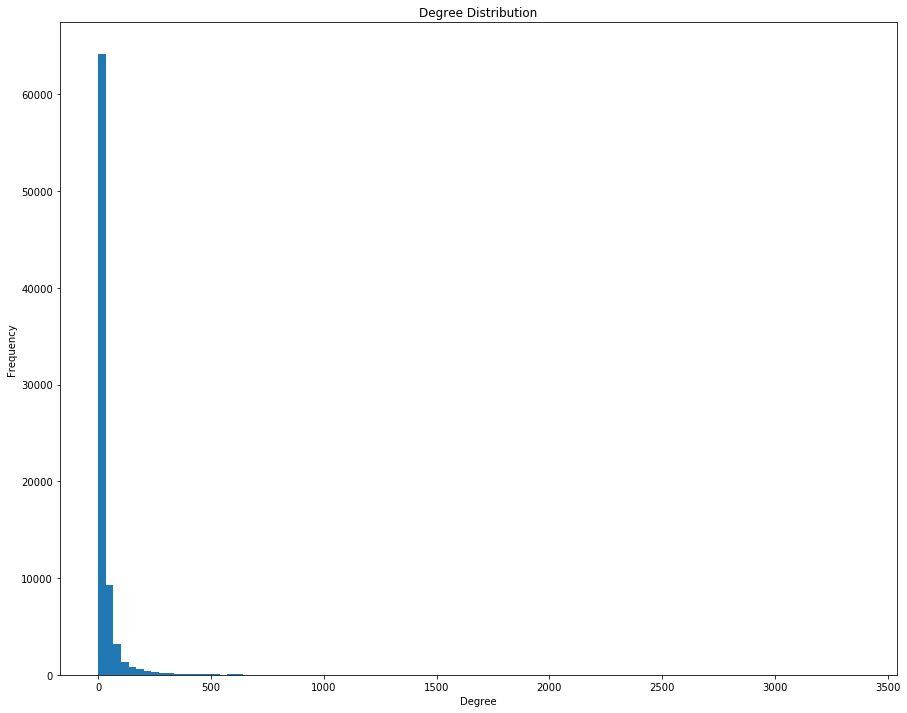

There are 81306 vertices
There are 2420766 edges
Graph density is 0.0007323909291994464


In [2]:
# datasets/facebook_combined.txt is from https://snap.stanford.edu/data/ego-Facebook.html
# DATASET_PATH = "datasets/facebook_combined.txt"; DIRECTED_EDGES = False

# datasets/twitter_combined.txt is from https://snap.stanford.edu/data/ego-Twitter.html
DATASET_PATH = "datasets/twitter_combined.txt"; DIRECTED_EDGES = True

with open(DATASET_PATH,"r") as f:
    edges = np.fromiter((int(n) for x in f.readlines() for n in x.split()), dtype='int')
    
# remap vertices to their indices
unique_vertices = np.unique(edges)
num_vertices = len(unique_vertices)
vertex_mapping = {vertex: i for i, vertex in enumerate(unique_vertices)}
edges = np.fromiter((vertex_mapping[vertex] for vertex in edges), dtype='int')
edges = edges.reshape((-1, 2))
del unique_vertices
del vertex_mapping

# Build graph
g = Graph(directed=DIRECTED_EDGES)  # NOTE: Twitter dataset is directed, Facebook dataset is undirected
g.add_vertex(num_vertices)
g.add_edge_list(edges)
g.vp.colour = g.new_vertex_property("vector<double>")
g.vp.state = g.new_vertex_property("int16_t")
g.vp.is_new_believer = g.new_vertex_property("bool")

plt.figure(figsize=(15, 12))
plt.hist(g.get_out_degrees(g.get_vertices()),bins=100)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.savefig('sim_output/degree_distribution.png')
plt.show()

p = g.num_vertices()
q = g.num_edges()
density = q  /  (p * (p - 1) / 2)
print('There are {0} vertices'.format(p))
print('There are {0} edges'.format(q))
print('Graph density is {0}'.format(density))

In [3]:
clustering_coefficient, clustering_coefficient_stddev = global_clustering(g)
print(f"Global clustering coefficient: {clustering_coefficient} (stddev: {clustering_coefficient_stddev})")

Global clustering coefficient: 0.36921857191489593 (stddev: 0.01635907811898651)


In [9]:
c = closeness(g)
pos = graph_tool.draw.sfdp_layout(g)
graph_draw(
    g, 
    pos=pos,
    vertex_fill_color=c,
    vertex_size=prop_to_size(c, mi=1, ma=4),
    vcmap=matplotlib.cm.gist_heat,
    edge_pen_width=0.3,
    vorder=c, 
    output_size=(5000, 5000),
    bg_color=[1,1,1,0.8],
    output="sim_output/SNAP_closeness.png"
)

Error: invalid matrix (not invertible)

In [5]:
pos = graph_tool.draw.sfdp_layout(g)

# Inferring structure of network with SBM
state = minimize_blockmodel_dl(g)
state.draw(pos=pos, bg_color=[0,0,0,1], output_size=(5000, 5000), output="sim_output/SNAP_blockmodel.png",)

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f54691e1b00, at 0x7f546909ce10>

## Monte Carlo Simulation

In [6]:
from datetime import datetime
from collections import namedtuple
from enum import Enum

np.random.seed(420)

class UserState(Enum):
    IGNORANT = 0
    SPREADER = 1
    STIFLER = 2

BACKGROUND_COLOR = [1, 1, 1, 0.8]
USER_STATE_COLORS = {
    UserState.IGNORANT: [0, 1, 0, 0.5],
    UserState.SPREADER: [1, 0, 0, 0.7],
    UserState.STIFLER: [0, 0, 1, 0.5],
}
NEW_BELIEVER_HALO_COLOR = [1, 1, 0, 1]
EDGE_COLOR = [0, 0, 0, 0.05]

IMAGE_SIZE = (2000, 2000)

SimulationResult = namedtuple("SimulationResult", ["first_spreader_idx", "first_spreader_degree", "time_step", "rumor_size"])

def simulate_rumour_spread(graph, model_parameters, first_spreader):
    time_step = 0
    yield time_step, graph.vp.state.a, graph.vp.is_new_believer.a
    while np.sum(graph.vp.state.a == UserState.SPREADER.value) > 0:
        time_step += 1
        graph.vp.is_new_believer.a = False

        all_spreaders = np.transpose((graph.vp.state.a == UserState.SPREADER.value).nonzero()).flatten()
        np.random.shuffle(all_spreaders)
        for spreader in all_spreaders: # visit every spreaders, in random order
            friends = graph.get_in_neighbours(spreader)
            friends_state = graph.vp.state.a[friends]
            ignorant_friends = friends[friends_state == UserState.IGNORANT.value]
            spreader_friends = friends[friends_state == UserState.SPREADER.value]
            stifler_friends = friends[friends_state == UserState.STIFLER.value]

            # if every friend is a stifler, we become a stifler as well
            # this is a performance optimization, since a spreader surrounded by only stiflers must eventually become a stifler themselves,
            # but this may take a long time so we'll just make them become a stifler immediately
            if np.all(friends_state == UserState.STIFLER.value):
                graph.vp.state.a[spreader] = UserState.STIFLER.value

            # when we share the rumour with ignorant friends, some believe it and become spreaders, and some do not and become stiflers
            random_threshold = np.random.random(len(ignorant_friends))
            new_believers = ignorant_friends[random_threshold < model_parameters['ignorant_believe_probability']]
            new_disbelievers = ignorant_friends[random_threshold >= model_parameters['ignorant_believe_probability']]
            graph.vp.state.a[new_believers] = UserState.SPREADER.value
            graph.vp.state.a[new_disbelievers] = UserState.STIFLER.value
            graph.vp.is_new_believer.a[new_believers] = True
            
            # when we share the rumour with spreader friends, if any have a different take on the rumour, we start to doubt the rumour and become a stifler
            # we assume each interaction is independent, so for N spreader friends this is P(X > 0) = 1 - P(X = 0) where X ~ Binomial(N, p), so 1 - (1 - p)^n
            if len(spreader_friends) > 0 and np.random.random() < 1 - (1 - model_parameters['spreader_disagreement_probability']) ** len(spreader_friends):
                graph.vp.state.a[spreader] = UserState.STIFLER.value
    
            # when we share the rumour with stifler friends, each one has a small chance of convincing us to doubt the rumour and become a stifler
            # we assume each interaction is independent, so for N stifler friends this is P(X > 0) = 1 - P(X = 0) where X ~ Binomial(N, p), so 1 - (1 - p)^n
            if len(stifler_friends) > 0 and np.random.random() < 1 - (1 - model_parameters['spreader_disillusionment_probability']) ** len(stifler_friends):
                graph.vp.state.a[spreader] = UserState.STIFLER.value
            
            # there's a random chance that we'll just forget about or lose interest in the rumour
            if np.random.random() < model_parameters['forget_probability']:
                graph.vp.state.a[spreader] = UserState.STIFLER.value
        yield time_step, graph.vp.state.a, graph.vp.is_new_believer.a


def run_simulations(graph, model_parameters, num_sims, draw=False):
    sims = []
    if draw:
        pos = graph_tool.draw.sfdp_layout(graph)
    for i in range(num_sims):
        if i % 25 == 0:
            print(f'{datetime.now()} RUNNING SIMULATION {i}'.format(i))

        # initially, no users in the network know about the rumour
        graph.vp.state.a = UserState.IGNORANT.value

        # introduce a single spreader who introduces the rumour to the network
        first_spreader = np.random.randint(0, graph.num_vertices())
        graph.vp.state.a[first_spreader] = UserState.SPREADER.value

        heard_rumour_fraction = []
        max_time_step = 0
        for time_step, state, is_new_believer in simulate_rumour_spread(g, model_parameters, first_spreader):
            heard_rumour_fraction.append(np.mean(state != UserState.IGNORANT.value))
            max_time_step = time_step

            if draw:
                for v in graph.vertices():
                    graph.vp.colour[v] = USER_STATE_COLORS[UserState(graph.vp.state[v])]
                graph_draw(
                    graph, pos=pos,
                    vertex_fill_color=graph.vp.colour, vertex_color=graph.vp.colour,
                    output_size=IMAGE_SIZE, bg_color=BACKGROUND_COLOR,
                    edge_pen_width=0.5, edge_color=EDGE_COLOR,
                    vertex_halo=graph.vp.is_new_believer, vertex_halo_color=NEW_BELIEVER_HALO_COLOR,
                    output=f'sim_output/sir_{i}_{time_step}.png'
                )

        sims += [SimulationResult(first_spreader, len(graph.get_in_neighbours(first_spreader)), max_time_step, heard_rumour_fraction)]
    return sims

model_parameters = {
    # when someone hears the rumour for the first time, 20% of the time they will believe it
    "ignorant_believe_probability": 0.2,
    
    # when spreader interacts with another spreader, 5% of the time the other spreader will have a different take on the rumour and the original spreader will become disillusioned
    "spreader_disagreement_probability": 0.05,

    # when a spreader interacts with a stifler, 10% of the time the spreader will become disillusioned by the stifler
    "spreader_disillusionment_probability": 0.1,

    # at each timestep, a spreader has a 50% chance of forgetting or losing interest in the rumour
    "forget_probability": 0.5,
}

In [7]:
print(datetime.now(), "START")
sims = run_simulations(g, model_parameters, num_sims=500)

# Pickle sim data to a file
with open("sim_output/sims_test.dat", "wb") as f:
    pickle.dump(sims, f)

2020-03-17 19:54:23.876471 START
2020-03-17 19:54:23.876612 RUNNING SIMULATION 0
2020-03-17 19:54:31.360317 RUNNING SIMULATION 25
2020-03-17 19:54:37.887400 RUNNING SIMULATION 50
2020-03-17 19:54:41.633495 RUNNING SIMULATION 75
2020-03-17 19:54:48.118285 RUNNING SIMULATION 100
2020-03-17 19:54:55.152125 RUNNING SIMULATION 125
2020-03-17 19:55:00.228132 RUNNING SIMULATION 150
2020-03-17 19:55:06.300143 RUNNING SIMULATION 175
2020-03-17 19:55:12.876128 RUNNING SIMULATION 200
2020-03-17 19:55:20.339461 RUNNING SIMULATION 225
2020-03-17 19:55:27.806341 RUNNING SIMULATION 250
2020-03-17 19:55:34.294706 RUNNING SIMULATION 275
2020-03-17 19:55:41.870892 RUNNING SIMULATION 300
2020-03-17 19:55:49.344978 RUNNING SIMULATION 325
2020-03-17 19:55:55.773920 RUNNING SIMULATION 350
2020-03-17 19:56:00.584448 RUNNING SIMULATION 375
2020-03-17 19:56:08.043026 RUNNING SIMULATION 400
2020-03-17 19:56:14.518012 RUNNING SIMULATION 425
2020-03-17 19:56:18.903746 RUNNING SIMULATION 450
2020-03-17 19:56:27.02

In [ ]:
print(datetime.now(), "START")
sims = run_simulations(g, model_parameters, num_sims=5, draw=True)

2020-03-17 20:48:53.395875 START
2020-03-17 20:52:02.995560 RUNNING SIMULATION 0


## Analysis

In [10]:
# Load simulation results file
with open("sim_output/sims_test.dat", "rb") as f:
    sims = pickle.load(f)

print(len(sims), "simulations loaded")

max_time_step = max(sim.time_step for sim in sims)
print("max time steps", max_time_step)

500 simulations loaded
max time steps 33


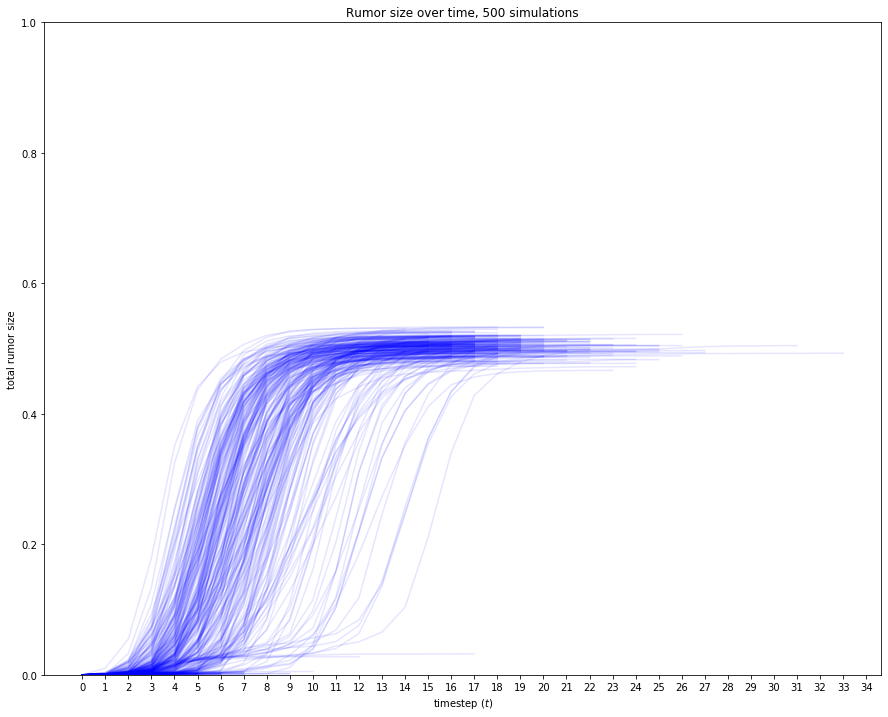

In [11]:
plt.figure(figsize=(15, 12))

for sim in sims:
    plt.plot(sim.rumor_size, alpha=0.1, color='b')

plt.ylim(0,1)
plt.xticks(range(max_time_step + 2))
plt.title(f'Rumor size over time, {len(sims)} simulations')
plt.xlabel('timestep ($t$)')
plt.ylabel('total rumor size')
plt.savefig('sim_output/rumor_size_over_time.png')
plt.show()

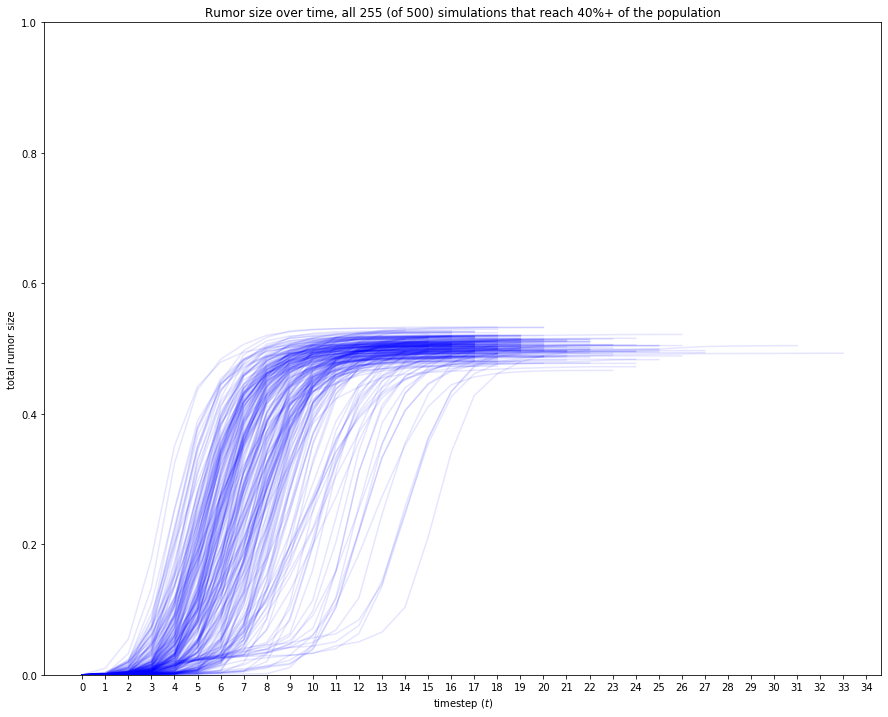

In [12]:
plt.figure(figsize=(15, 12))

large_sims = [sim for sim in sims if sim.rumor_size[-1] > 0.4]
for sim in large_sims:
    plt.plot(sim.rumor_size,alpha=0.1,color='b')

plt.ylim(0, 1)
plt.xticks(range(max_time_step + 2))
plt.title(f'Rumor size over time, all {len(large_sims)} (of {len(sims)}) simulations that reach 40%+ of the population')
plt.xlabel('timestep ($t$)')
plt.ylabel('total rumor size')
plt.savefig('sim_output/rumor_size_over_time_large_sims_only.png')

plt.show()

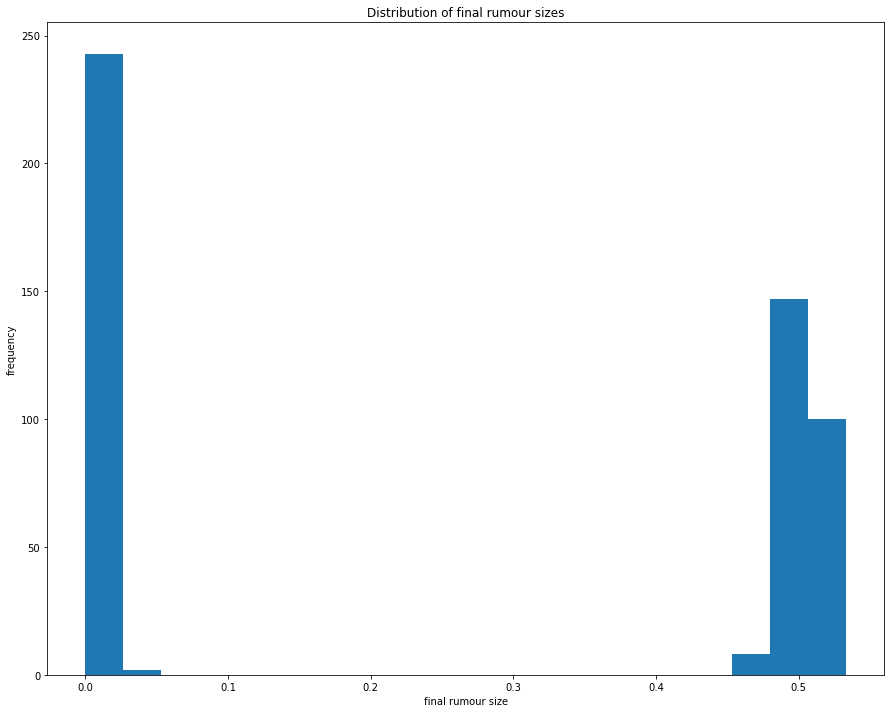

In [13]:
plt.figure(figsize=(15, 12))

plt.hist([sim.rumor_size[-1] for sim in sims], bins=20)

plt.title('Distribution of final rumour sizes')
plt.xlabel('final rumour size')
plt.ylabel('frequency')
plt.savefig('sim_output/rumour_size_distribution.png')
plt.show()

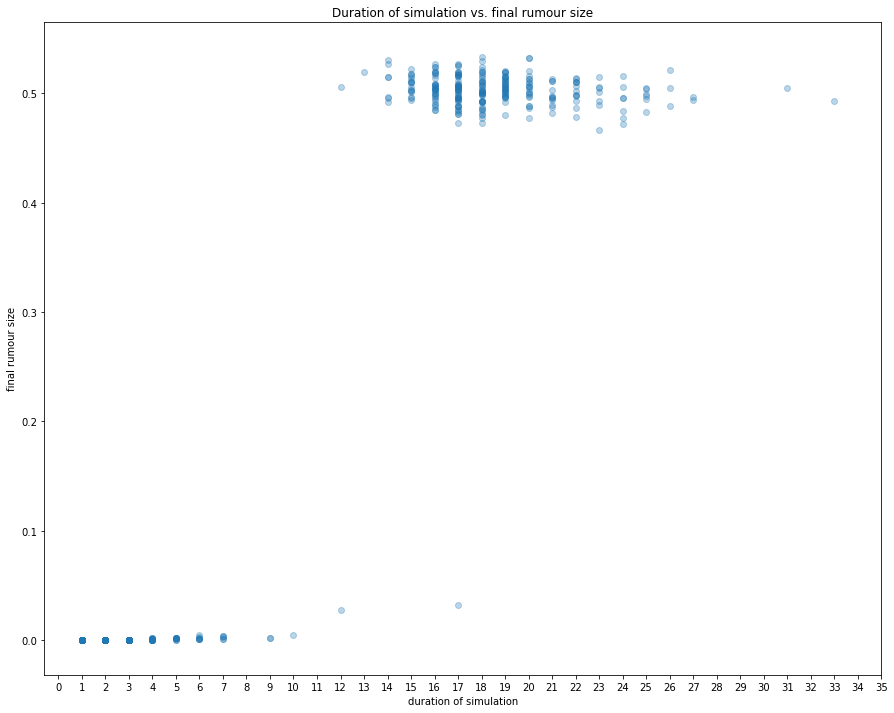

In [14]:
plt.figure(figsize=(15, 12))

plt.scatter([sim.time_step for sim in sims], [sim.rumor_size[-1] for sim in sims], alpha=0.3)

plt.title('Duration of simulation vs. final rumour size')
plt.xlabel('duration of simulation')
plt.ylabel('final rumour size')
plt.xticks(range(max_time_step + 3))
plt.savefig('sim_output/sim_duration_vs_rumour_size.png')
plt.show()

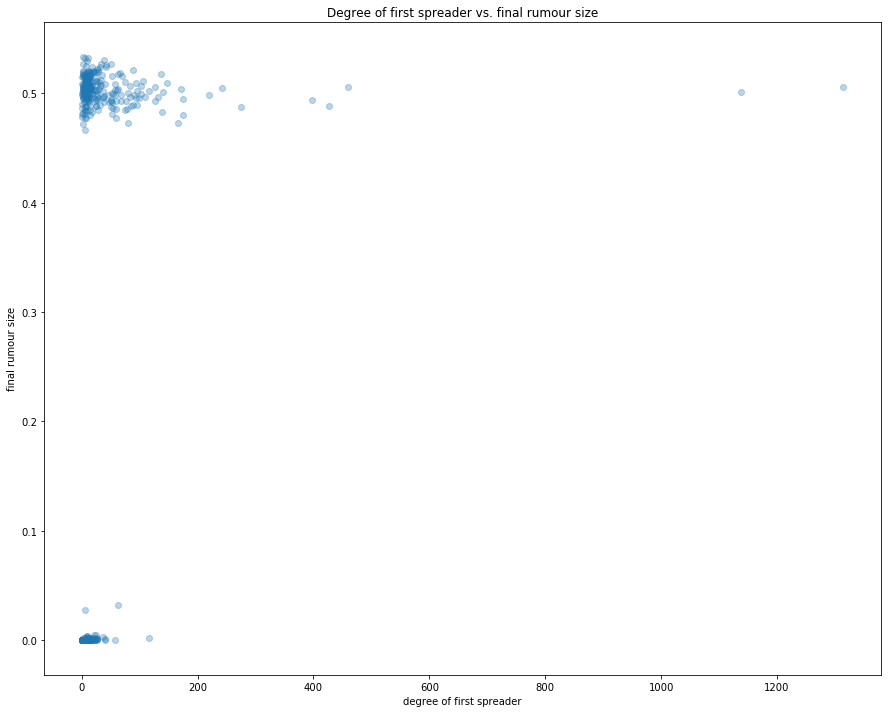

In [15]:
plt.figure(figsize=(15, 12))

plt.scatter([sim.first_spreader_degree for sim in sims], [sim.rumor_size[-1] for sim in sims], alpha=0.3)

plt.title('Degree of first spreader vs. final rumour size')
plt.xlabel('degree of first spreader')
plt.ylabel('final rumour size')
plt.savefig('sim_output/first_spreader_degree_vs_rumour_size.png')
plt.show()